# Generate Word Embeddings

In an effort to learn NLP predictive word embedding models CBOW and Skip-Gram, I have taken inspiration from https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa 
to generate both models from scratch followed by implementation using Gensim

I also use GloVe model and the FastText model in this model to cover all the bases

## 1. Load the data

I'll be using King James Version of the Bible available from Project Gutenberg available through nltk 

In [1]:
import nltk 

In [2]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt')
print(bible[0:20])

[['[', 'The', 'King', 'James', 'Bible', ']'], ['The', 'Old', 'Testament', 'of', 'the', 'King', 'James', 'Bible'], ['The', 'First', 'Book', 'of', 'Moses', ':', 'Called', 'Genesis'], ['1', ':', '1', 'In', 'the', 'beginning', 'God', 'created', 'the', 'heaven', 'and', 'the', 'earth', '.'], ['1', ':', '2', 'And', 'the', 'earth', 'was', 'without', 'form', ',', 'and', 'void', ';', 'and', 'darkness', 'was', 'upon', 'the', 'face', 'of', 'the', 'deep', '.'], ['And', 'the', 'Spirit', 'of', 'God', 'moved', 'upon', 'the', 'face', 'of', 'the', 'waters', '.'], ['1', ':', '3', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'light', ':', 'and', 'there', 'was', 'light', '.'], ['1', ':', '4', 'And', 'God', 'saw', 'the', 'light', ',', 'that', 'it', 'was', 'good', ':', 'and', 'God', 'divided', 'the', 'light', 'from', 'the', 'darkness', '.'], ['1', ':', '5', 'And', 'God', 'called', 'the', 'light', 'Day', ',', 'and', 'the', 'darkness', 'he', 'called', 'Night', '.'], ['And', 'the', 'evening', 'and', 'the', 

Text is pre-tokenized but has not been processed

## 2. Text Preprocessing

In [3]:
import numpy as np
import re

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters, leading and tailing whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize
    tokens = wpt.tokenize(doc)
    # filter out stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # recreate a cleaner version of the doc from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

# vectorize the normalize_document function so it can take a list of docs 
normalize_corpus = np.vectorize(normalize_document)

In [4]:
%%time
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
# combine the tokens
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
# Process the text and create a filter iterator removing None
norm_bible = filter(None, normalize_corpus(norm_bible))
# only keep docs with more than two words
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

Wall time: 3.65 s


## 3. Generate Word Embeddings

Word embeddings are essentially a form of word representation such that each word is represented as a vector.  There are two major techniques used for generating word embeddings: 
    1. Frequency-based word embeddings, and
    2. Prediction-based word embeddings

Here I will only be using prediction-based (Word2Vec) models to generate word embeddings, by first creating my own CBOW and Skip-gram models (see below for descriptions) and then using the efficient implementation from Ginsem.  

General information about different methods for generating word embeddings follows.

###  Frequency-based word embeddings 
Three different types of methods that fall under this category:
    1. Count vector
    2. TFIDF vector
    3. Co-occurrence vector

####  Count Vector
This method of generating word embeddings counts the frequency of each word in a corpus. 

#### TFIDF (Term frequency-inverse document frequency)
Rather than look at absolute frequency per corpus, it looks at relative frequency, i.e., TFIDF tries to infer the frequency of a term in a document relative to its frequency in all the documents combined.  For example, climbing related words will be present at a relatively higher frequency in a climbing-related article on a blog; however, terms like 'the', 'a', 'at', 'and' will be present at a near equal frequency.  Therefore, climbing-related words would have a higher TFIDF score. 

#### Co-occurrence matrix
How likely two terms are to appear in a corpus. Context window can be used to limit the area of search within a corpus. SVD (singular value decomposition) is a varition on this concept. 

### Prediction-based word embeddings
Methods such as <b>Word2Vec</b> use NN to predict word representations. Two different types:
    1. CBOW (Continuous Bag of Words)
    2. Skip-Gram

They functionally use a deep learning classification model such that given the context words as input X, they try to predict the target word, Y. 

A really excellent article here helps explain the intuition and logic behind Word2Vec: http://jalammar.github.io/illustrated-word2vec/

#### CBOW
CBOW uses a shallow neural network to predict the probability of word given its context, typically a group of words before and after the word. More here: https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-cbow.html

#### Skip-Gram
Essentially the same as CBOW but rather than predict the probabiliy of a word based on its context, it predicts the context based on a group of words. More here: https://towardsdatascience.com/skip-gram-nlp-context-words-prediction-algorithm-5bbf34f84e0c

### Explanation of Word2Vec
Word2Vec uses a single hidden layer. Neurons in the hidden layer are all linear neurons. The input layer is equal to the size of vocabulary, i.e., the total number of words in the cleaned document.  For example, the vocabulary size `vocab_size` for this example is 12,425.  Each of these words is represented as a one-hot vector.  Therefore, each vector has shape `1 X V`, where V = vocab_size. 

We will also have a weight matrix, Wi, of shape `V x N`, where V = vocab_size as above and N is the number of word embeddings.  In this project I will use N = 300, which is typical and was the same number used by Mikolov et al. at Google. However, in the first image below, N = 4 and the second image below, N = 50.

Multiplying the one-hot vector with the W1 matrix has the same effect of selecting the word-specific row from the Wi matrix.  This leads to our __hidden neurons__: there will be N of these neurons each of shape `1 X V`.

For example: 

<img src="images/input_layer.png" alt="word embedding example" title="word embedding example" />

[Source](https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1>)

Extending the analogy, multiplying a one-hot vector representing queen, woman, girl, etc. in the example below, with a Wi matrix of shape V X 50, i.e., 50 word embeddings leads to the following matrix. 
<img src="images/queen-woman-girl-embeddings.png" alt="word embedding example" title="word embedding example" />

[Source](http://jalammar.github.io/illustrated-word2vec/)

Similarly, the connections from the hidden layer to output layer can be described by matrix Wo of size `N x V`, which returns the `1 x V` output vector.

Wi is the __Embedding Matrix__. Our goal is to train the hidden layer weight matrix, i.e., Embedding matrix, and we'll toss out the output layer when done.  The embedding matrix is, wait for it..., the word embeddings that we are interested in.

An excellent example of Word2Vec: https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1

### 3.1 CBOW
Build a CBOW model from scratch to learn the intuition behind it. 

Implement the following steps:
1. __Build the corpus vocabulary__
2. __Build a CBOW (context, target) generator__
3. __Build the CBOW model architecture__
4. __Train the CBOW model__
5. __Get word embeddings__
    
Each of the steps is implemented below

#### 3.1.1 Build the corpus vocabulary

In [5]:
%%time
from keras.preprocessing import text
from keras.utils import np_utils

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

# build vocabulary of unique words
# zero index
word2id['PAD'] = 0
# flip keys and values
id2word = {v:k for k,v in word2id.items()}
# convert words to ids for each doc
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id) 
embed_size = 50 
window_size = 2 # context window size

Using TensorFlow backend.


Wall time: 2.64 s


In [6]:
print('Vocabulary size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:20])

Vocabulary size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10), ('man', 11), ('israel', 12), ('king', 13), ('son', 14), ('hath', 15), ('people', 16), ('came', 17), ('house', 18), ('come', 19), ('one', 20)]


#### 3.1.2 Build a CBOW (context, target) generator

In [7]:
from keras.preprocessing import sequence

def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2 # 2 words on the left and 2 words on the right
    for words in corpus: 
        sentence_length = len(words)
        
        for idx, word in enumerate(words):
            context_words = []
            label_word = []
            start = idx - window_size
            end = idx + window_size + 1
            
            context_words.append([words[i] for i in range(start, end) if 0 <= i < sentence_length and i != idx])
            label_word.append(word)
            # pad x with zeroes to bring all context vectors to the same length, i.e., window size
            x = sequence.pad_sequences(context_words, maxlen=context_length)
            # one-hot encode the label word vectors. 
            y = np_utils.to_categorical(label_word, vocab_size)
            # remember the current state so the next execution starts with the next doc
            yield (x, y)
            

# Test
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
        
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


#### 3.1.3 Build the CBOW model architecture

Inputs are going to be context words, which are then passed on to the embedding layer initialized with random weights. These embeddings are then passed to the lambda layer where the word embeddings are averaged, which are further propagated to a dense softmax layer, which predicts the target word.  Then, compare the prediction to the actual target word, compute the loss using `categorical_crossentropy` loss. 
Lastly, backpropagate through the model with each epoch to updated the embedding layers. 

In [8]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW arhitecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size, )))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

print(cbow.summary())






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 50)             621250    
_________________________________________________________________
lambda_1 (Lambda)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12425)             633675    
Total params: 1,254,925
Trainable params: 1,254,925
Non-trainable params: 0
_________________________________________________________________
None


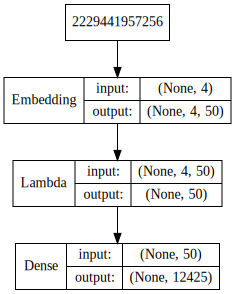

In [9]:
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False,
                 rankdir='TB').create(prog='dot', format='svg'))

#### 3.1.4 Train the model

In [11]:
from tqdm import tqdm

# Takes a long time, so only training for 5 epochs
for epoch in tqdm(range(1, 6)):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Process {} (context, word) pairs'.format(i))
            
    print('Epoch: ', epoch, '\tloss:', loss)
    print()

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Process 100000 (context, word) pairs
Process 200000 (context, word) pairs
Process 300000 (context, word) pairs


 20%|████████████████                                                                | 1/5 [24:02<1:36:08, 1442.23s/it]

Epoch:  1 	loss: 4113339.187493472

Process 100000 (context, word) pairs
Process 200000 (context, word) pairs
Process 300000 (context, word) pairs


 40%|████████████████████████████████                                                | 2/5 [48:18<1:12:18, 1446.33s/it]

Epoch:  2 	loss: 4456532.418619491

Process 100000 (context, word) pairs
Process 200000 (context, word) pairs
Process 300000 (context, word) pairs


 60%|████████████████████████████████████████████████                                | 3/5 [1:12:34<48:18, 1449.46s/it]

Epoch:  3 	loss: 4355113.974081609

Process 100000 (context, word) pairs
Process 200000 (context, word) pairs
Process 300000 (context, word) pairs


 80%|████████████████████████████████████████████████████████████████                | 4/5 [1:38:05<24:33, 1473.82s/it]

Epoch:  4 	loss: 4414522.699706539

Process 100000 (context, word) pairs
Process 200000 (context, word) pairs
Process 300000 (context, word) pairs


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [2:05:03<00:00, 1500.63s/it]

Epoch:  5 	loss: 4387419.5647815745



__Get Word Embeddings__

In [13]:
import pandas as pd

weights = cbow.get_weights()[0] #exclude the 'PAD'
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(12424, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
unto,-0.111497,0.002653,0.579934,-0.205533,-0.257777,0.683210,-1.062372,0.673639,-2.215195,-0.691394,...,-0.578701,-0.214132,-0.674522,0.298975,-1.191875,-0.827905,0.464316,-0.632226,-2.271042,-1.242007
lord,0.222377,-0.862549,0.098993,0.842632,0.520697,0.946461,-0.887865,2.325035,-1.242840,-0.996246,...,-0.886935,0.983131,-1.084204,-0.504667,-0.555553,-1.394730,0.140336,-1.050796,-1.897477,-1.547574
thou,0.556728,0.789585,0.839923,1.566497,0.357915,-1.689836,-1.371404,2.166498,-1.515055,-0.870104,...,-0.639378,-0.491298,-1.006866,-0.033204,-1.106964,-0.094809,0.714532,0.156659,-1.110116,0.017525
thy,-0.083314,1.368226,1.038154,-0.140101,0.064538,-1.507040,-0.248452,1.222694,-1.537247,-0.911090,...,-0.679611,-0.921405,-0.109028,0.118880,-0.915350,-0.151728,-0.023250,0.016615,-0.797362,-1.141463
god,0.875957,0.339052,0.415746,0.684717,-0.124675,-1.441555,-0.760216,0.496472,-2.127209,-0.833413,...,-0.431499,0.226416,0.184447,0.767303,-1.123816,-0.140877,0.536728,-0.449372,-1.160343,-0.655197


Word embeddings for some of the words.  Each word is represented as a 1x50 vector. We can now use these embeddings to find some contextually similar words by comparing other word vectors that are closest to our word of interest

In [15]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

(12424, 12424)


In [17]:
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

{'god': ['things', 'hath', 'us', 'many', 'also'],
 'jesus': ['many', 'spirit', 'holy', 'dead', 'without'],
 'noah': ['rachel', 'inner', 'bondage', 'setteth', 'ninety'],
 'egypt': ['dwell', 'inhabitants', 'philistines', 'throughout', 'destroy'],
 'john': ['angels', 'pharisees', 'dream', 'peter', 'ship'],
 'gospel': ['preached', 'church', 'pharisees', 'churches', 'goods'],
 'moses': ['told', 'work', 'wilderness', 'gave', 'gate'],
 'famine': ['strangers', 'break', 'possession', 'remain', 'dust']}

Some of the words make sense and some are completely nonsensical.  Training for more epochs and/or increasing the size of the embedding matrix would have certainly helped but we were limited by resources.  Will be able to get better results using Gensim's implementation of Word2Vec discussed later

### 3.2 Skip-gram Model

Essentially the opposite of the CBOW model such that it tries to predict the context words (surrounding words) given the target word (the center word).  For example, in the sentence "Highball climbs are dangerous but addictive for adrenaline junkies who love the exposure", with a window size of 3, we would get pairs like __***([highball, climbs, are], dangerous]), ([highball, are, dangerous], climbs)]***__ etc. and the task of the Skip-gram model is to predict the context __***([highball, climbs, are)]***__ given the word dangerous. 

Rather than predict several context words, the task is simplified by breaking down each __***(target, context_words) pair***__ into __***(target, context) pairs***__ so that each context consists of only one word.  In the example above, the data set will get transformed into word pairs like __***(dangerous, highball), (dangerous, climbs), (dangerous, are), (climbs, highball), (climbs, are), (climbs, dangerous)***__ etc. 

The Skip-gram model takes word pairs __***(X, Y)***__ as positive input labels, where X is the input and Y is the label. We also add negative input samples with the negative label 0, so that we don't end up with a smart ass model that always predicts 1. 

Implement the following steps:
1. __Build the corpus vocabulary__
2. __Build a skip-gram [(target, context), relevancy] generator
3. __Build the skip-gram model architecture__
4. __Train the skip-gram model__
5. __Get word embeddings__

Each of the steps is implemented below

#### 3.2.1 Build the corpus vocabulary

This is similar to what we did for CBOW

In [18]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1
embed_size = 300

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size: ', vocab_size)
print('Vocabulary Sample: ', list(word2id.items())[:20])

Vocabulary Size:  12425
Vocabulary Sample:  [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10), ('man', 11), ('israel', 12), ('king', 13), ('son', 14), ('hath', 15), ('people', 16), ('came', 17), ('house', 18), ('come', 19), ('one', 20)]


#### 3.2.2 Build a Skip-gram [(target, context), relevancy] generator

This should produce word pairs as discussed above including words with positive and negative labels. As an example, should get word pairs like [(dangerous, highball), 1], [(dangerous, keyboard), 0], [(dangerous, music), 0], [(climbs, highball), 1], [(climbs, lamp), 0], [(climbs, eating), 0]

Going to use the `skipgrams` module in `keras` rather than generate these manually

In [19]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(12):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
        id2word[pairs[i][0]], pairs[i][0],
        id2word[pairs[i][1]], pairs[i][1],
        labels[i]))

(james (1154), zarhites (4375)) -> 0
(king (13), bible (5766)) -> 1
(bible (5766), james (1154)) -> 1
(bible (5766), bury (1321)) -> 0
(james (1154), bible (5766)) -> 1
(bible (5766), whoredom (2005)) -> 0
(king (13), doubletongued (12184)) -> 0
(king (13), marcus (6732)) -> 0
(king (13), james (1154)) -> 1
(bible (5766), king (13)) -> 1
(james (1154), king (13)) -> 1
(james (1154), sucklings (5392)) -> 0


#### 3.2.3 Build the skip-gram model architecture

For the skip-gram model, inputs will be the (target word, context word/random word) pairs. These will be passed to an embedding layer, which will be passed to a merge layer where we will calculate the dot product of these two vectors.  The result will be passed to a dense sigmoid layer, which will predict either a 1 or a 0. This will be compared to the relevance label Y.  We will then compute the loss using `mean_squared_error` and perform backpropagation with each epoch to update the embedding layer. 

Wi is the __Embedding Matrix__ and Wo is the __Context Matrix__.  Great [example](http://jalammar.github.io/illustrated-word2vec/) below. 

<img src="images/word2vec-embedding-context-matrix.png" alt="Embedding and Context Matrices" title="Embedding and Context Matrices">

In [20]:
from keras.layers import Embedding, Reshape, Activation, Input
from keras.layers.merge import Dot
from keras.models import Sequential, Model

# build skip-gram architecture

# inputs

word_inputs = Input(shape=(1, ), dtype='int32')
word_layer = Embedding(vocab_size, embed_size, embeddings_initializer='glorot_uniform', 
                       input_length=1)(word_inputs)

# context
context_inputs = Input(shape=(1, ), dtype='int32')
context_layer = Embedding(vocab_size, embed_size, embeddings_initializer='glorot_uniform', 
                          input_length=1)(context_inputs)
output_layer = Dot(axes=2)([word_layer, context_layer])
output_layer = Reshape((1, ), input_shape=(1, 1))(output_layer)
output_layer = Activation('sigmoid')(output_layer)

SkipGram = Model(inputs=[word_inputs, context_inputs], outputs=output_layer)
SkipGram.compile(loss='mean_squared_error', optimizer='rmsprop')

# view model summary
print(SkipGram.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 300)       3727500     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 300)       3727500     input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

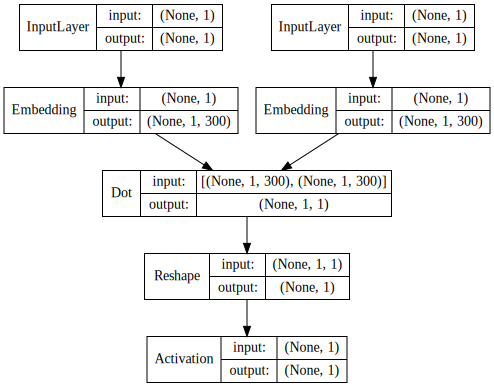

In [21]:
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(SkipGram, show_shapes=True, show_layer_names=False,
                 rankdir='TB').create(prog='dot', format='svg'))

#### 3.2.4 Train the Model

Since the SkipGram model is faster, we can train embeddings of size 1x300

In [22]:
from tqdm import tqdm

for epoch in range(1, 6):
    loss = 0
    for i, elem in tqdm(enumerate(skip_grams)):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 100000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += SkipGram.train_on_batch(X, Y)
    
    print('Epoch: ', epoch, 'Loss: ', loss)

0it [00:00, ?it/s]

Processed 0 (skip_first, skip_second, relevance) pairs


29251it [05:46, 84.52it/s]
9it [00:00, 87.58it/s]

Epoch:  1 Loss:  4633.532965586986
Processed 0 (skip_first, skip_second, relevance) pairs


29251it [05:45, 84.60it/s]
9it [00:00, 85.16it/s]

Epoch:  2 Loss:  4055.227727582562
Processed 0 (skip_first, skip_second, relevance) pairs


29251it [05:48, 84.02it/s]
9it [00:00, 87.61it/s]

Epoch:  3 Loss:  3801.074449525564
Processed 0 (skip_first, skip_second, relevance) pairs


29251it [05:52, 83.07it/s]
18it [00:00, 87.88it/s]

Epoch:  4 Loss:  3587.741944949259
Processed 0 (skip_first, skip_second, relevance) pairs


29251it [05:48, 83.84it/s]

Epoch:  5 Loss:  3427.519965562853


In [47]:
weights = SkipGram.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(12424, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
shall,0.175546,-0.046667,0.028631,-0.158408,-0.256606,-0.146081,0.139758,0.009051,-0.151753,0.188567,...,0.035225,0.488038,-0.010256,0.089852,-0.057847,-0.110794,0.123456,-0.042647,0.105005,0.076737
unto,0.180589,0.085601,-0.021342,-0.243338,-0.270256,-0.054418,-0.081295,0.041875,0.043078,-0.172489,...,0.093761,0.305242,0.125636,0.585698,-0.252802,-0.502518,0.238837,0.086943,0.163825,0.126180
lord,0.152301,0.054021,-0.036179,-0.474064,-0.350991,-0.115683,-0.002338,0.058352,0.163229,0.354080,...,0.121311,0.468477,0.202906,0.205272,-0.056493,-0.477098,-0.011891,0.232368,0.018860,0.145230
thou,0.504381,0.101638,-0.026953,-0.426909,-0.575932,-0.083835,-0.241006,0.107553,0.038230,-0.362670,...,-0.084734,0.127347,0.088495,-0.027279,-0.212870,-0.401038,-0.117544,0.024930,0.315518,0.388501
thy,0.340432,-0.171347,0.052193,0.101346,0.237562,-0.048883,0.028505,-0.139582,-0.185348,-0.140442,...,0.022113,0.435666,0.115957,0.228734,0.112396,-0.226342,-0.023137,-0.003823,0.372280,-0.004965


In [49]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12424, 12424)


{'god': ['lord', 'forasmuch', 'times', 'sanctified', 'gifts'],
 'jesus': ['disciples', 'paul', 'faith', 'peter', 'john'],
 'noah': ['shem', 'ham', 'sixty', 'terah', 'japheth'],
 'egypt': ['pharaoh', 'egyptians', 'caused', 'countries', 'served'],
 'john': ['simon', 'synagogue', 'peter', 'apostles', 'galilee'],
 'gospel': ['preach', 'preached', 'apostles', 'resurrection', 'baptism'],
 'moses': ['charge', 'kept', 'joseph', 'sanctify', 'testimony'],
 'famine': ['pestilence', 'inhabited', 'devoured', 'scatter', 'desolation']}

Results are somewhat better than CBOW partly due to the increased embedding size. 

Total words: 48 	Word Embedding shapes: (48, 300)


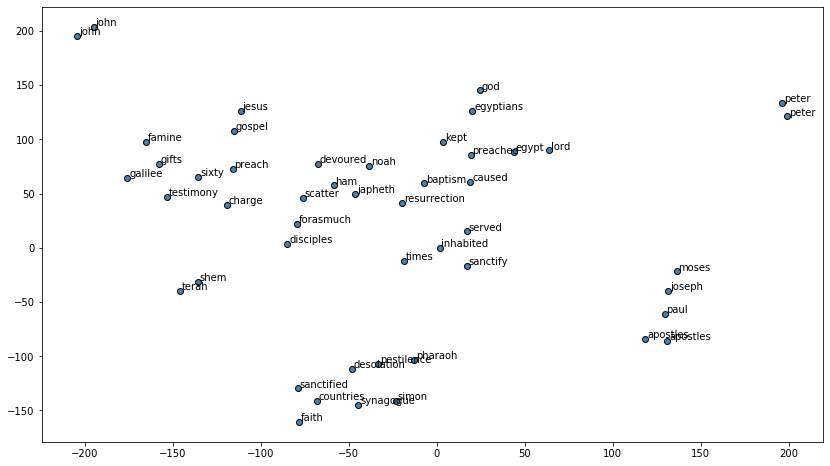

In [51]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### 3.3 Word2Vec models with Gensim

The `gensim` framework, created by Radim Řehůřek consists of a robust, efficient and scalable implementation of the Word2Vec model. 

In [52]:
from gensim.models import word2vec

# tokenize sentences in corpus 
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(doc) for doc in norm_bible]

# Set parameter values
embed_size = 300 # word embedding dimension
window_context = 7 # context window size
min_word_count = 1 # minimum word count
sample = 1e-3 # downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=embed_size, window=window_context, 
                              min_count=min_word_count, sample=sample, iter=100)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                    for search_term in ['god', 'jesus', 'noah', 'john', 'israel',
                                        'adam', 'eve', 'famine', 'moses', 'jonas']}
similar_words

{'god': ['lord', 'unto', 'thee', 'therefore', 'hath'],
 'jesus': ['john', 'synagogue', 'simon', 'messias', 'nathanael'],
 'noah': ['shem', 'hoglah', 'methuselah', 'mahlah', 'japheth'],
 'john': ['james', 'baptist', 'peter', 'devine', 'jesus'],
 'israel': ['lord', 'judah', 'people', 'fathers', 'unto'],
 'adam': ['enoch', 'seth', 'enosh', 'kenan', 'zibia'],
 'eve': ['proclaimeth', 'enosh', 'rachab', 'ammonitess', 'upharsin'],
 'famine': ['pestilence', 'peril', 'blasting', 'mildew', 'sharpened'],
 'moses': ['congregation', 'aaron', 'sinai', 'joshua', 'doctor'],
 'jonas': ['ninevites', 'mibhar', 'joel', 'ezbai', 'machi']}

Visualize the Gensim word embeddings

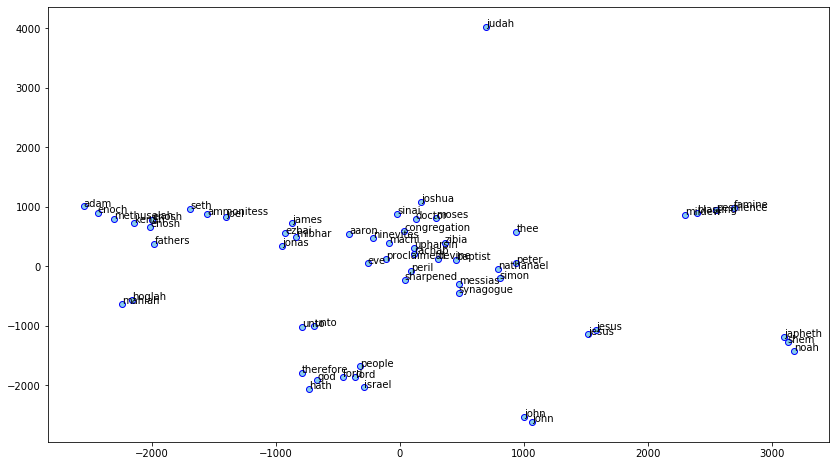

In [53]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='skyblue', edgecolors='b')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## 4. Applying Word2Vec word embeddings for ML tasks

Now that the implementations of CBOW and Skip-Gram are clear, we can apply the features learned (word embeddings) to actual ML tasks

### 4.1 Build a sample corpus

In [54]:
import pandas as pd

# build a corpus
corpus = ["Bishop high ball bouldering is scary",
          "Bishop has amazing high ball bouldering",
          "The roads are wet with rain and snow today.", 
          "High ball bouldering in Bishop is world famous", 
          "Not excited about the rain and snow road conditions!",
          "I don't like driving on roads during rain and snow",
          "Chiweenie Pedro, Heeler Eva, and Terrier Josie love hiking", 
          "Pedro is a chiweenie, Eva is a heeler and Josie is a terrier"]

labels = ['climbing', 'climbing', 'weather', 'climbing', 'weather', 'weather',
          'animals', 'animals']

norm_corpus = normalize_corpus(corpus)

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})

corpus_df

,Document,Category
0,Bishop high ball bouldering is scary,climbing
1,Bishop has amazing high ball bouldering,climbing
2,The roads are wet with rain and snow today.,weather
3,High ball bouldering in Bishop is world famous,climbing
4,Not excited about the rain and snow road condi...,weather
5,I don't like driving on roads during rain and ...,weather
6,"Chiweenie Pedro, Heeler Eva, and Terrier Josie...",animals
7,"Pedro is a chiweenie, Eva is a heeler and Josi...",animals


### 4.2 Build Word2Vec model using Gensim

In [86]:
#from gensim import word2vec

# build word2vec model
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(doc) for doc in norm_corpus]

# Set parameter values
embed_size = 12
window_context = 8
min_word_count = 1
sample = 1e-3

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=embed_size, window=window_context, 
                              min_count = min_word_count, sample=sample, iter=100)

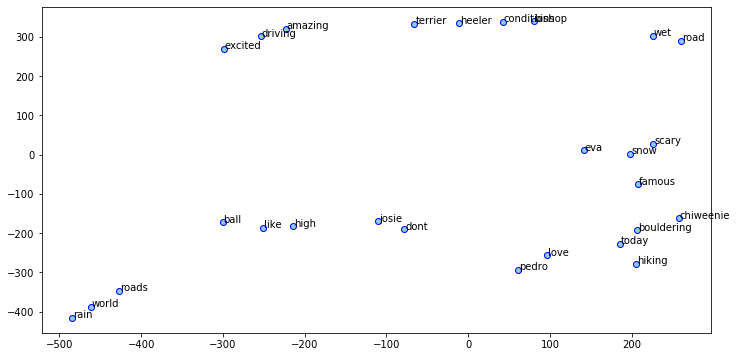

In [87]:
# visualize embeddings
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c="skyblue", edgecolors='b')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

Even in this example with tiny data sample, the model can already start to group certain words together, which is impressive

In [88]:
w2v_model.wv['bishop']

array([ 0.02221681,  0.01129859,  0.02253174,  0.04110599, -0.01195471,
        0.02634234,  0.01982546, -0.029606  , -0.01468022,  0.01961123,
       -0.04086495, -0.00336187], dtype=float32)

Representation of the word 'bishop' in word embeddings

### 4.3 Cluster the documents in the corpus

Next step is to try to cluster the 13 documents in the corpus. A reasonable strategy is to average the word embeddings for each word in the document to get document-level word embeddings

#### 4.3.1 Build document-level word embeddings

In [89]:
import numpy as np
import pandas as pd

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features), dtype='float64')
    nwords = 0.
    
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
            # add each word's embeddings to the previous vector (feature_vector)
        
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)
            # divide by the number of words. 
        
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features)

# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model, num_features=embed_size)
pd.DataFrame(w2v_feature_array)

C:\Users\aksin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.006809,-0.000466,0.002885,0.003395,-0.004207,-0.004385,0.004847,-0.004403,0.006562,-0.006930,0.002632,-0.009457
1,-0.000433,0.004090,-0.000068,-0.007836,-0.002920,-0.001005,0.007700,-0.001089,0.007094,-0.001039,-0.004405,-0.006331
2,0.001327,0.006416,0.005357,-0.007343,0.003621,0.001328,0.004297,-0.000051,0.004523,0.000398,0.003324,-0.005435
3,-0.003052,-0.004810,-0.000848,-0.004556,0.001797,0.002668,0.002224,-0.006413,0.002651,-0.004695,-0.004680,-0.001641
4,-0.003267,0.007348,0.004288,0.006665,-0.006162,0.003149,0.003441,-0.003239,-0.001414,-0.001364,-0.004252,-0.005912
5,-0.000175,-0.004511,0.003637,0.001854,0.000834,-0.004002,0.006003,-0.003716,0.003033,-0.000120,-0.000847,-0.005250
6,0.002359,0.002521,-0.003773,-0.003218,0.004847,-0.000259,0.003155,-0.000368,0.002961,0.005611,0.002066,-0.002709
7,0.002144,-0.003821,-0.001910,0.005280,-0.007265,-0.004929,0.001099,-0.003240,0.005051,0.007693,-0.002224,0.003139


#### 4.3.2 Cluster documents

Use __***Affinity Propagation***__ clustering algorithm, which differs from partition-based algorithms like ***k-means*** in that the number of clusters do not need to be provided a priori as an explicit input. Afinity propagation finds "exemplars", members of the input set that are representative of clusters.

In [90]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,Bishop high ball bouldering is scary,climbing,2
1,Bishop has amazing high ball bouldering,climbing,0
2,The roads are wet with rain and snow today.,weather,0
3,High ball bouldering in Bishop is world famous,climbing,2
4,Not excited about the rain and snow road condi...,weather,1
5,I don't like driving on roads during rain and ...,weather,2
6,"Chiweenie Pedro, Heeler Eva, and Terrier Josie...",animals,0
7,"Pedro is a chiweenie, Eva is a heeler and Josi...",animals,2


Model is able to correctly classify many of the docs, but struggles with some unique words which is understandable with the little amount of data it is working with

#### 4.3.3 Visualize clustered documents

Use __***Principal Component Analysis (PCA)***__ to reduce feature dimensions to 2-D to visualize the documents and how they are clustered together

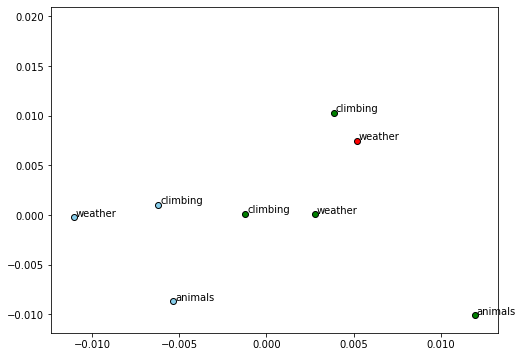

In [91]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'skyblue' if label == 0 else 'red' if label == 1 else 'green' if label ==2 else 'cyan'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-4), xytext=(0, 0), textcoords='offset points')

The visualization confirms the model output, but shows more clearly why thereis confusion.  It classifies `animals` correctly, but struggles to classify `climbing` and `weather`

## The GloVe (Global Vectors) Model

This is an unsupervised learning model, which can be used to obtain dense word vectors similar to Word2Vec. However, in this model, training is performed on aggregated global word-word co-occurrence matrix. 

Frequency-based methods like Latent Semantic Analysis (LSA) efficiently leverage statistical information but do relatively poorly on word analogy tasks like skip-gram, whereas skip-gram models poorly use the statistics of corpus on a global level. 

GloVe models aims to remedy these issues, by fkrst creating a word-context co-occurence matrix consisting on (word, context) pairs such that each elmeent in this matrix represents how often a word occurs with the context, e.g., a sequence of words. It then applies matrix factorization (as in SVD) to approximate this matrix. 

In [92]:
norm_corpus

array(['bishop high ball bouldering scary',
       'bishop amazing high ball bouldering', 'roads wet rain snow today',
       'high ball bouldering bishop world famous',
       'excited rain snow road conditions',
       'dont like driving roads rain snow',
       'chiweenie pedro heeler eva terrier josie love hiking',
       'pedro chiweenie eva heeler josie terrier'], dtype='<U52')

In [97]:
import spacy
import en_core_web_lg

nlp = en_core_web_lg.load()
total_vectors = len(nlp.vocab.vectors)
print('Total word vectors: ', total_vectors)

Total word vectors:  684831


In [98]:
import pandas as pd

unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))

# get glove word embeddings
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
conditions,0.033569,0.430010,-0.495430,-0.199020,-0.390770,-0.592390,0.067223,0.414760,0.105950,2.40190,...,-0.398390,0.592940,-0.057197,-0.924110,0.230930,-0.267670,-0.246150,0.102760,0.406520,-0.347190
wet,0.293710,-0.376840,0.014916,-0.432360,-0.235330,-0.202590,-0.104680,-0.122730,-0.426270,1.19010,...,0.246570,0.244900,0.249980,-0.632150,-0.302800,0.251830,-0.097462,0.126950,0.164320,-0.547800
famous,0.473940,-0.082606,-0.315980,-0.351850,0.415330,0.481740,0.339010,0.015607,-0.050311,2.36110,...,0.022298,0.131230,-0.448600,0.356350,-0.018035,0.206030,0.665580,0.090997,0.297950,0.227660
eva,-0.344460,-0.157740,0.492310,-0.642420,0.282490,0.110900,0.264480,-0.203860,-0.049396,-0.48312,...,0.722120,0.070981,0.087894,-0.172150,0.504290,-0.672100,-0.027502,-0.174400,0.221010,-0.006855
hiking,0.461570,0.032175,-0.112010,-0.686760,0.648630,0.932600,-0.401150,0.123070,-0.378220,1.75220,...,0.340230,-0.198400,-0.160910,-0.533730,-0.087608,-0.158440,0.469700,0.191010,0.318120,-0.560500
today,-0.156570,0.594890,-0.031445,-0.077586,0.278630,-0.509210,-0.066350,-0.081890,-0.047986,2.80360,...,-0.326580,-0.413380,0.367910,-0.262630,-0.203690,-0.296560,-0.014873,-0.250060,-0.115940,0.083741
road,0.741110,0.566330,-0.181880,-0.125740,0.350830,0.223120,-0.170100,0.006058,-0.113250,2.63900,...,-0.344290,-0.009742,0.255500,-0.119080,0.037643,-0.161070,0.329600,0.164490,-0.086237,-0.249660
bishop,0.634010,-0.055211,-0.224050,-0.017958,0.375680,0.323760,-0.164030,0.636150,-0.250870,2.37620,...,0.206770,-0.457740,-0.513480,-0.185700,-0.447360,-0.232930,0.231000,0.738850,-0.241710,-0.681670
ball,0.380240,0.290390,0.145150,-0.158740,0.128250,-0.575170,0.143360,0.553360,0.117970,1.67620,...,0.373550,-0.152270,0.113770,-0.155270,0.096394,-0.193880,-0.134450,-0.090520,0.086341,0.401290
bouldering,0.065985,0.411500,-0.299380,-0.451200,0.842240,0.453580,-0.152880,0.895940,-0.347360,-0.11161,...,0.200750,-0.557960,0.262470,-0.492310,-0.064861,-0.034919,-0.244950,-0.033222,0.102960,0.125730


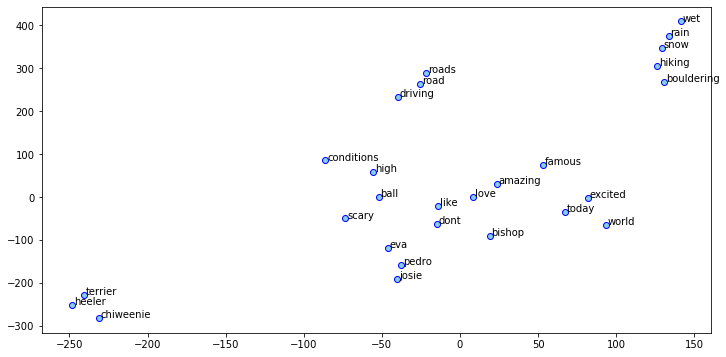

In [99]:
# visualize
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='skyblue', edgecolors='b')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')


This time we'll use K Means clustering with n = 3

In [100]:
from sklearn.cluster import KMeans

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,Bishop high ball bouldering is scary,climbing,1
1,Bishop has amazing high ball bouldering,climbing,1
2,The roads are wet with rain and snow today.,weather,0
3,High ball bouldering in Bishop is world famous,climbing,1
4,Not excited about the rain and snow road condi...,weather,0
5,I don't like driving on roads during rain and ...,weather,0
6,"Chiweenie Pedro, Heeler Eva, and Terrier Josie...",animals,2
7,"Pedro is a chiweenie, Eva is a heeler and Josi...",animals,2


The GloVe model classifies all the documents accurately clearly outperforming the Word2Vec model

## 5. FastText Model using Gensim

In [101]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(doc) for doc in norm_bible]

embed_size = 100
window_context = 50
min_word_count = 5
sample = 1e-3

# sg decides whether to use the skip-gram model (1) or CBOW(0)
ft_model = FastText(tokenized_corpus, size=embed_size, window=window_context, 
                   min_count=min_word_count, sample=sample, sg=1, iter=50)

# view similar words based on gensim's FastText model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'john', 'israel',
                                        'adam', 'eve', 'famine', 'moses', 'jonas']}
similar_words

{'god': ['lord', 'jesus', 'unto', 'us', 'therefore'],
 'jesus': ['christ', 'god', 'faith', 'disciples', 'grace'],
 'noah': ['methuselah', 'flood', 'milcah', 'creepeth', 'mahalaleel'],
 'john': ['baptist', 'baptize', 'peter', 'galilee', 'philip'],
 'israel': ['children', 'lord', 'judah', 'people', 'spake'],
 'adam': ['seth', 'methuselah', 'adah', 'enoch', 'mahalaleel'],
 'eve': ['ever', 'sanctification', 'established', 'lovingkindness', 'god'],
 'famine': ['pestilence', 'sword', 'dearth', 'blasted', 'sojourn'],
 'moses': ['aaron', 'commanded', 'congregation', 'spake', 'israel'],
 'jonas': ['condemn', 'jonah', 'sign', 'generation', 'preaching']}

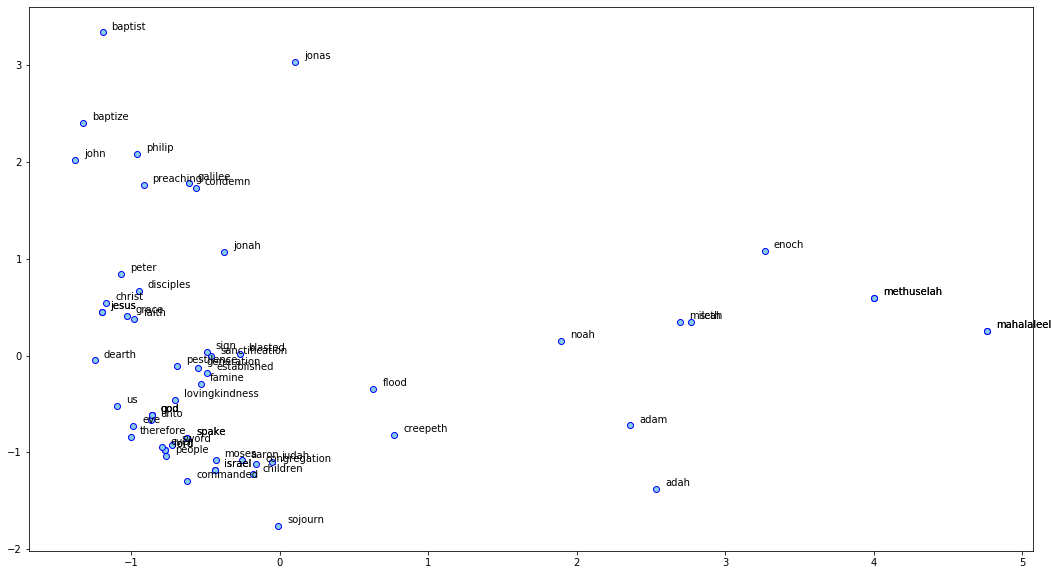

In [102]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='skyblue', edgecolors='b')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [103]:
# can use the model to find similarities
print(ft_model.wv.similarity(w1='moses', w2='pharaoh'))
print(ft_model.wv.similarity(w1='god', w2='jesus'))

0.45624152
0.68263924


In [105]:
st1 = "god jesus satan john"
print('Odd one out for [',st1, ']:',  
      ft_model.wv.doesnt_match(st1.split()))
st2 = "john peter james judas"
print('Odd one out for [',st2, ']:', 
      ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ god jesus satan john ]: satan
Odd one out for [ john peter james judas ]: judas
